# Run segmentation on cropped images of astrocytes

In this file, we perform the following steps:
1) Load frustums informations regarding a particular scene
2) Crop the images of the scene given the frustums
3) Run segmentation on each cropped image

In [2]:
# Imports
import os
import cv2
import json
import glob
import torch
import random
import oiffile
import numpy as np
import seaborn as sns
import pytorch_lightning as pl
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision.utils import save_image
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from celldet_utils import output2file, save_cropped_astro_masks, construct_slices_tensor

/home/yemika/Public/anaconda3/envs/celldet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configs
frustums_list_path = "output/ClusteredPredictionsPlots/FrustumsPerCluster/frustums_list.json" # Obtain from group_3d.ipynb
images_dir = "data/slices/half/all_slices2_done_predictions/"
output_dir = "data/slices/half/all_slices2_done_masks/"
oib_path = "data/slices/half/all_slices2_done/cup1_20x_1.oib"

# Rigid configs
image_format = ".png"

# Create the required directories
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Load the frustums list
with open(frustums_list_path, 'r') as f:
    frustums_list = json.load(f)
n_frustums = len(frustums_list)
print(f"Loaded {n_frustums} frustums from {frustums_list_path}")

Loaded 101 frustums from output/ClusteredPredictionsPlots/FrustumsPerCluster/frustums_list.json


In [5]:
# Load the images
images_list = sorted(glob.glob(os.path.join(images_dir, "*" + image_format)))
n_images = len(images_list)
print(f"Loaded {n_images} images from {images_dir}")

Loaded 21 images from data/slices/half/all_slices2_done_predictions/


In [6]:
# Crop the images
cropped_images = []
images_list_pil = []
for image_path in tqdm(images_list):
    # Retrieve the image and its z-coordinate
    image = Image.open(image_path).convert('RGB')
    images_list_pil.append(image)
    z = float(image_path.split('/')[-1].split('.')[0])
    
    for frustum in frustums_list:
        within_frustum = frustum['z2'] >= z >= frustum['z1']
        
        # Crop the image if within the frustum z-range
        if within_frustum:
            x_min = frustum['x1']
            x_max = frustum['x2']
            y_min = frustum['y1']
            y_max = frustum['y2']
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            cropped_image_info = {
                "x1": x_min,
                "x2": x_max,
                "y1": y_min,
                "y2": y_max,
                "z": z,
                "image": cropped_image,
                "frustum_id": frustum['cluster']
            }
            cropped_images.append(cropped_image_info)
n_cropped_images = len(cropped_images)
print(f"Extracted {n_cropped_images} cropped images")

100%|██████████| 21/21 [00:00<00:00, 70.94it/s]

Extracted 1527 cropped images


## Visualize cropped images

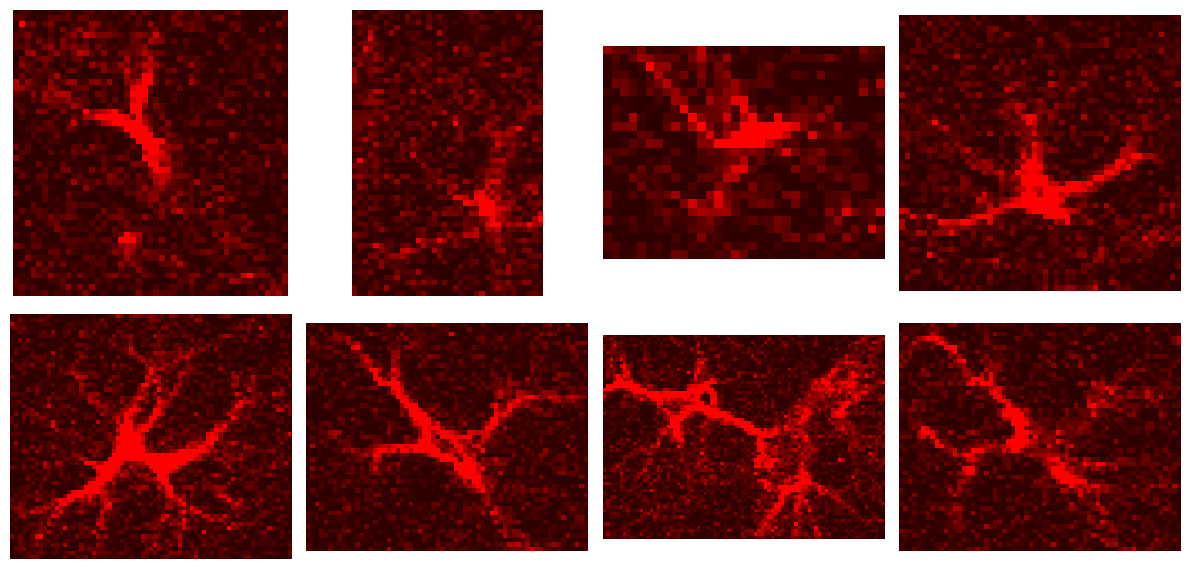

In [7]:
# Create a 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the 2D array of subplots for easier iteration
axs = axs.flatten()

# Loop through each image and display it in a subplot
for i, image in enumerate(random.sample(cropped_images, k=8)):
    axs[i].imshow(image['image'])
    axs[i].axis('off')  # Turn off axis labels

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Run through the segmentation model

In [8]:
SIZE = 192
N_INPUT_CHANNEL = 3
N_CLASSES = 3

class NucleiTypes:
    BACKGROUND = 0
    NUCLEUS = 1
    BORDER = 2

NUCLEI_CLASS_MAP = {
    0: NucleiTypes.BACKGROUND,
    1: NucleiTypes.NUCLEUS,
    2: NucleiTypes.BORDER
}

NUCLEI_CLASSES = len(set(NUCLEI_CLASS_MAP.values()))


# Define the path to the segmentation model
nuclei_model_list = [
    {
        "architecture": "unet",
        "encoder_name": "resnet34",
        "weight": "lightning_logs_astro/version_0/checkpoints/epoch=45-step=736.ckpt"
    }
]
preprocessing_fn = get_preprocessing_fn('resnet50', pretrained='imagenet')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SegmentationCell(pl.LightningModule):
    def __init__(self, architecture="unet", encoder_name="resnet34"):
        super().__init__()

        # TODO: add more architecture if you like
        if architecture == "unet":
            self.model = smp.Unet(
                encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=N_INPUT_CHANNEL,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=NUCLEI_CLASSES,                      # model output channels (number of classes in your dataset)
            )
        elif architecture == "unet++":
            self.model = smp.UnetPlusPlus(
                encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=N_INPUT_CHANNEL,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=NUCLEI_CLASSES,                      # model output channels (number of classes in your dataset)
            )
        elif architecture == "manet":
            self.model = smp.MAnet(
                encoder_name=encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=N_INPUT_CHANNEL,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=NUCLEI_CLASSES,                      # model output channels (number of classes in your dataset)
            )

    def forward(self, x):
        return self.model(x.float())


# Load nuclei models (this can be 1 or 3 models)
nuclei_models = [
    SegmentationCell.load_from_checkpoint(
        model_config["weight"],
        architecture=model_config["architecture"],
        encoder_name=model_config["encoder_name"]
    ).to(device)
    for model_config in nuclei_model_list[:1]
]

def ensemble_prediction(image_batch, *models):
    """
    This function is for doing prediction using ensemble models
    """
    with torch.no_grad():
        for model in models:
            model.eval()

        logits = [model(image_batch.to(device)) for model in models]
        logits = [torch.nn.functional.softmax(logit, dim=1).cpu() for logit in logits]
        logits = np.concatenate([logit[:, :, np.newaxis, :, :] for logit in logits], axis=2)

        logits = np.mean(logits, axis=2)

    return logits

def get_segmentation_nuclei(image):
    """
    Get the cropped of the cell, predict the mask and return the mask in the original shape
    """
    # we only need to get 1 channel for the nuclei
    image = np.array(image)[:, :, 0:1]
    image = np.repeat(image, 3, axis=-1)

    original_h, original_w, _ = image.shape

    image = cv2.resize(image, (192, 192))

    image = preprocessing_fn(image)

    image = image.transpose(2, 0, 1)
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).float()

    with torch.no_grad():
        #output = nuclei_segmentation_model.model(image).numpy()
        output = ensemble_prediction(image, *nuclei_models)
        output = output[0].transpose(1, 2, 0).argmax(axis=-1, keepdims=True).astype(np.uint8)
        output = np.expand_dims(cv2.resize(output, (original_w, original_h)), axis=-1)

    return output

Lightning automatically upgraded your loaded checkpoint from v1.9.1 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint lightning_logs_astro/version_0/checkpoints/epoch=45-step=736.ckpt`


In [9]:
# Initialize the model and load the weights
weights_path = "lightning_logs_astro/version_0/checkpoints/epoch=45-step=736.ckpt"
model = SegmentationCell()
model.load_state_dict(torch.load(weights_path)['state_dict'])

<All keys matched successfully>

In [10]:
# Run through all images and extract segmentation masks
for idx in tqdm(range(n_cropped_images)):
    image = cropped_images[idx]
    model.eval()

    # Construct the input
    image = torch.tensor(np.array(image['image']))
    mask = get_segmentation_nuclei(image)
    cropped_images[idx]['mask'] = mask

100%|██████████| 1527/1527 [00:14<00:00, 105.28it/s]


In [11]:
# Saving cropped masks and images
cropped_astro_masks_save_dir = os.path.join(output_dir, "cropped_astrocyte_masks_per_frustum")
print(f"Saving cropped masks and images of astrocytes to {cropped_astro_masks_save_dir}")
save_cropped_astro_masks(cropped_images, cropped_astro_masks_save_dir)

Saving cropped masks and images of astrocytes to data/slices/half/all_slices2_done_masks/cropped_astrocyte_masks_per_frustum


## Reconstruct the slice masks

In [12]:
# Get the list of unique z-coordinates
unique_zs = sorted(set([image_info['z'] for image_info in cropped_images]))
print(f"Identified {len(unique_zs)} unique z-coordinates")

# Initialize empty masks per slice
slice_masks = {unique_z: torch.zeros((800, 800, 1)) for unique_z in unique_zs}

# Populate the masks
for cropped_image_info in tqdm(cropped_images):
    x_min = int(cropped_image_info['x1'])
    x_max = int(cropped_image_info['x2'])
    y_min = int(cropped_image_info['y1'])
    y_max = int(cropped_image_info['y2'])
    z = cropped_image_info['z']
    mask = cropped_image_info['mask']

    # Account for potential discrepancies in coordinates when putting the masks back
    if x_max - x_min != mask.shape[1] or y_max - y_min != mask.shape[0]:
        x_max = x_min + mask.shape[1]
        y_max = y_min + mask.shape[0]

    # Replace the mask
    slice_masks[z][y_min:y_max, x_min:x_max] = torch.tensor(mask)

# Save the masks
astrocyte_masks_dir = os.path.join(output_dir, "astrocyte_masks")
os.makedirs(astrocyte_masks_dir, exist_ok=True)
print(f"Saving the masks to {astrocyte_masks_dir}")
for k, v in slice_masks.items():
    save_path = os.path.join(astrocyte_masks_dir, f"mask_{str(int(k))}.png")
    save_image(v.permute(2, 0, 1) / 2., save_path) # 2 classes, hence divide by 2

Identified 21 unique z-coordinates


100%|██████████| 1527/1527 [00:00<00:00, 42226.49it/s]

Saving the masks to data/slices/half/all_slices2_done_masks/astrocyte_masks


/tmp/ipykernel_31126/4126157053.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


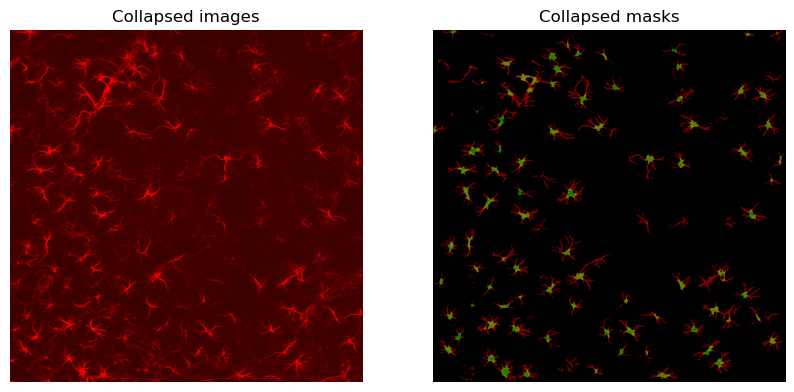

In [13]:
# Collapse the masks
collapsed_mask = torch.max(torch.stack(list(slice_masks.values())), dim=0)[0]
collapsed_image = torch.mean(torch.stack([torch.tensor(np.array(image) / 255.) for image in images_list_pil]), dim=0)

# Color different classes
branch_mask = (torch.sum((torch.stack(list(slice_masks.values())).squeeze(3) == 1).float(), dim=0) != 0).float()
nuclei_mask = (torch.sum((torch.stack(list(slice_masks.values())).squeeze(3) == 2).float(), dim=0) != 0).float()
colored_branch_mask = torch.zeros(size=(branch_mask.shape[0], branch_mask.shape[1], 3))
colored_nuclei_mask = torch.zeros(size=(nuclei_mask.shape[0], nuclei_mask.shape[1], 3))
branch_color = torch.tensor([1., 0., 0.])
nuclei_color = torch.tensor([0., 1., 0.])
colored_branch_mask[[branch_mask == 1]] = branch_color
colored_nuclei_mask[[nuclei_mask == 1]] = nuclei_color
collapsed_mask = (colored_branch_mask + colored_nuclei_mask) / 2.

# Create a figure with two collapsed images
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 5))
ax1[0].imshow(collapsed_image)
ax1[0].set_title('Collapsed images')
ax1[1].imshow(collapsed_mask)
ax1[1].set_title('Collapsed masks')
for ax in ax1:
    ax.axis('off')
fig1.show()

# # Create a heatmap
# fig2, ax2 = plt.subplots()
# ax2.imshow(collapsed_image, alpha=0.5)
# cax = ax2.imshow(collapsed_mask, cmap='hot', alpha=0.5)  # Adjust the alpha value for transparency
# cbar = fig.colorbar(cax, ax=ax2)
# fig2.show()

## Run masking on the nuclei

In [14]:
# Define the path to the segmentation model
nuclei_model_list = [
    {
        # Old model
        # "architecture": "unet",
        # "encoder_name": "resnet34",
        # "weight": "lightning_logs_nuclei/version_0/checkpoints/epoch=38-step=1131.ckpt"

        # New model
        "architecture": "unet++",
        "encoder_name": "resnet50",
        "weight": "lightning_logs_nuclei/version_0/checkpoints/epoch=141-step=4118.ckpt"
    }
]

# Initialize the models ensemble
nuclei_models = [
    SegmentationCell.load_from_checkpoint(
        model_config["weight"],
        architecture=model_config["architecture"],
        encoder_name=model_config["encoder_name"]
    ).to(device)
    for model_config in nuclei_model_list[:1]
]

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint lightning_logs_nuclei/version_0/checkpoints/epoch=141-step=4118.ckpt`


In [15]:
def save_segmented_nuclei(oib_path, save_dir):
    """
    Take .oib files from source folder, extract images with nuclei, segmentate it and save it in destination folder
    """
    # Create directory if is doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Load nuclei images and run segmentation on them
    nuclei = oiffile.imread(oib_path)[0, ...]
    n_nuclei = len(nuclei)
    print(f"Running segmentation on {n_nuclei} slices of the nuclei channel")
    for idx, image in tqdm(enumerate(nuclei), total=n_nuclei):
        image = np.expand_dims(image, axis=-1)
        output = get_segmentation_nuclei(image)

        # Save the grayscale output
        save_path = os.path.join(save_dir, f"{idx:03}.png")
        output2file(output, 2., save_path)
        
        # Color the output
        colored_output = np.repeat(output, repeats=3, axis=-1)
        colored_output[np.squeeze(output, axis=-1)==0] = np.array([0., 0., 0.])
        colored_output[np.squeeze(output, axis=-1)==1] = np.array([0., 0., 1.])
        colored_output[np.squeeze(output, axis=-1)==2] = np.array([0., 1., 0.])

        # Save the colored output
        save_path = os.path.join(save_dir, f"colored_{idx:03}.png")
        output2file(colored_output, 1., save_path)


def save_nuclei_from_oib(oib_path, save_dir):
    """
    Take .oib files from source folder, extract images with nuclei and save it in destination folder
    """
    # Create directory if is doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    nuclei = oiffile.imread(oib_path)[0, ...]
    n_nuclei = len(nuclei)

    # Save the nuclei images
    print(f"Saving {n_nuclei} images of nuclei slices")
    for idx, image in tqdm(enumerate(nuclei), total=n_nuclei):
        image = np.expand_dims(image, axis=-1).astype(np.float32)
        image = np.repeat(image, 3, axis=-1)
        image[..., 0] = 0  # Set the red channel to 0
        image[..., 2] = 0  # Set the blue channel to 0
        
        # Save the image
        # save_path = os.path.join(destination_folder, f"{file_name}_{idx:03}.png")
        save_path = os.path.join(save_dir, f"{idx:03}.png")
        output2file(image, 4095., save_path) # 16-bit image, therefore 4095

In [16]:
# Slice the OIB file to save the nuclei channel
nuclei_images_save_dir = "data/slices/half/all_slices2_done_nuclei/"
save_nuclei_from_oib(oib_path=oib_path, save_dir=nuclei_images_save_dir)

Saving 21 images of nuclei slices


100%|██████████| 21/21 [00:04<00:00,  4.39it/s]


In [17]:
# Segment the nuclei and save them
segmented_nuclei_save_dir = os.path.join(output_dir, "nuclei_slice_masks")
save_segmented_nuclei(oib_path=oib_path, save_dir=segmented_nuclei_save_dir)

Running segmentation on 21 slices of the nuclei channel


100%|██████████| 21/21 [00:02<00:00,  8.05it/s]


## Zoomed segmentation of the nuclei

Zoom into wherever astrocytes were detected, and perform segmentation of the nuclei there.

In [18]:
# Load the images of nuclei
nuclei_images_list = sorted(glob.glob(os.path.join(nuclei_images_save_dir, "*.png")))
nuclei_images_dict = {float(nuclei_image_path.split('/')[-1].split('.')[0]): np.array(Image.open(nuclei_image_path)) / 255. for nuclei_image_path in nuclei_images_list}
print(f"Loaded {len(nuclei_images_dict)} images of nuclei slices")

# Initialize empty nuclei masks
nuclei_masks = {k: torch.zeros((v.shape[0], v.shape[1], 1)) for k, v in nuclei_images_dict.items()}

# For each frustum, run segmentation on the corresponding part of the nuclei slices
print(f"Running segmentation on cropped nuclei images for {len(cropped_images)} frustums")
for idx in tqdm(range(n_cropped_images)):
    cropped_image_info = cropped_images[idx]
    x1 = int(cropped_image_info['x1'])
    x2 = int(cropped_image_info['x2'])
    y1 = int(cropped_image_info['y1'])
    y2 = int(cropped_image_info['y2'])
    z = cropped_image_info['z']
    w, h = cropped_image_info['image'].size

    # Select the corresponding nuclei image
    nuclei_image = torch.tensor(nuclei_images_dict[z])
    cropped_nuclei_image = nuclei_image[y1:y1 + h, x1:x1 + w]
    
    # Replicate the green channel in the red and blue channels
    cropped_nuclei_image[..., 0] = cropped_nuclei_image[..., 1]
    cropped_nuclei_image[..., 2] = cropped_nuclei_image[..., 1]

    # Run segmentation
    cropped_nuclei_image = cropped_nuclei_image * 255.
    output = get_segmentation_nuclei(cropped_nuclei_image)

    # Save the mask
    cropped_images[idx]['nuclei-mask'] = output
    nuclei_masks[z][y1:y1 + h, x1:x1 + w] = torch.tensor(output)

Loaded 21 images of nuclei slices
Running segmentation on cropped nuclei images for 1527 frustums


100%|██████████| 1527/1527 [00:39<00:00, 39.04it/s]


In [19]:
# Record the nuclei masks to the frustums list
for idx in range(n_frustums):
    frustum_idx = frustums_list[idx]['cluster']

    # Collect all slices corresponding to this frustum ID
    slices_per_frustum = {cropped_image['z']: torch.tensor(cropped_image['nuclei-mask']).float() for cropped_image in cropped_images if cropped_image['frustum_id'] == frustum_idx}
    slices_per_frustum = dict(sorted(slices_per_frustum.items())) # Sort the dictionary by the z coordinate
    slice_3d_frustum = construct_slices_tensor(slices_per_frustum).squeeze(3) # Squeeze the last channel

    # Assign the 3D mask to the frustum
    frustums_list[frustum_idx]['nuclei-mask3d'] = slice_3d_frustum

In [20]:
# Save the nuclei masks
nuclei_zoomed_segmentation_save_dir = os.path.join(output_dir, "nuclei_zoomed_masks")
os.makedirs(nuclei_zoomed_segmentation_save_dir, exist_ok=True)
for idx, (k, v) in enumerate(nuclei_masks.items()):
    save_path = os.path.join(nuclei_zoomed_segmentation_save_dir, f"{idx:03}.png")
    save_image(v.permute(2, 0, 1) / 2., save_path)
    
    # Color the output
    output = np.array(v)
    colored_output = np.repeat(output, repeats=3, axis=-1)
    colored_output[np.squeeze(output, axis=-1)==0] = np.array([0., 0., 0.])
    colored_output[np.squeeze(output, axis=-1)==1] = np.array([0., 0., 1.])
    colored_output[np.squeeze(output, axis=-1)==2] = np.array([0., 1., 0.])

    # Save the colored output
    save_path = os.path.join(nuclei_zoomed_segmentation_save_dir, f"colored_{idx:03}.png")
    output2file(colored_output, 1., save_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([21, 800, 800, 1])
torch.Size([])


Text(0.5, 1.0, 'Collapsed astrocyte + nuclei mask')

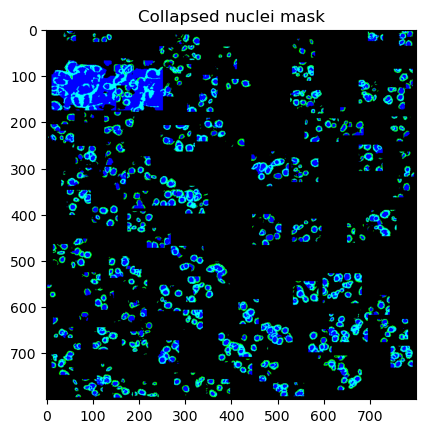

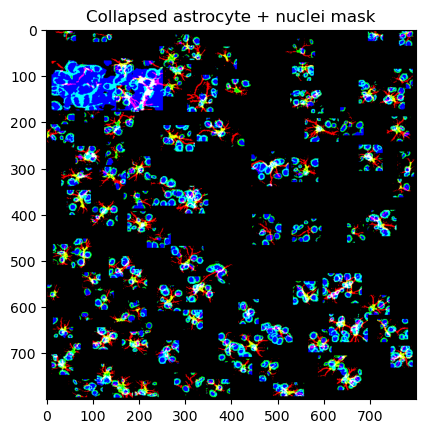

In [21]:
# Collapse the masks and show them
colored_masks = []
grayscale_masks = []
for idx, nuclei_mask in enumerate(nuclei_masks.values()):
    grayscale_masks.append(nuclei_mask)
    colored_mask = torch.zeros((nuclei_mask.shape[0], nuclei_mask.shape[1], 3))
    colored_mask[nuclei_mask.squeeze(2) == 0] = torch.tensor([0., 0., 0.])
    colored_mask[nuclei_mask.squeeze(2) == 1] = torch.tensor([0., 0., 1.])
    colored_mask[nuclei_mask.squeeze(2) == 2] = torch.tensor([0., 1., 0.])
    colored_masks.append(colored_mask)

grayscale_collapsed_mask = torch.stack(grayscale_masks)
print(grayscale_collapsed_mask.shape)
blue_mask = torch.sum(grayscale_collapsed_mask[grayscale_collapsed_mask == 1.].float(), dim=0)
print(blue_mask.shape)

# Plot the collapsed nuclei mask
collapsed_nuclei_mask = torch.sum(torch.stack(colored_masks), dim=0)
fig, ax = plt.subplots()
ax.imshow(collapsed_nuclei_mask)
ax.set_title("Collapsed nuclei mask")

# Plot the astrocyte+nuclei collapsed masks
fig, ax = plt.subplots()
ax.imshow(collapsed_nuclei_mask + 10 * collapsed_mask)
ax.set_title("Collapsed astrocyte + nuclei mask")

# 3D BFS and Branch Coloring

In [22]:
# Construct a 3D tensor for each frustum
print("Constructing 3D masks for all frustums")
for idx in range(n_frustums):
    frustum_idx = frustums_list[idx]['cluster']

    # Collect all slices corresponding to this frustum ID
    slices_per_frustum = {cropped_image['z']: torch.tensor(cropped_image['mask']).float() for cropped_image in cropped_images if cropped_image['frustum_id'] == frustum_idx}
    slices_per_frustum = dict(sorted(slices_per_frustum.items())) # Sort the dictionary by the z coordinate
    slice_3d_frustum = construct_slices_tensor(slices_per_frustum).squeeze(3) # Squeeze the last channel

    # Assign the 3D mask to the frustum
    frustums_list[frustum_idx]['mask3d'] = slice_3d_frustum

Constructing 3D masks for all frustums


In [23]:
# Define the function that performs connection checks
from queue import Queue
def bfs3d(mask):
    def bfs(mask, start, visited, cluster_id):
        rows, cols, depth = mask.size()
        directions = [
            (1, 0, 0), 
            (-1, 0, 0), 
            (0, 1, 0), 
            (0, -1, 0),
            (0, 0, 1),
            (0, 0, -1)
        ]  # Possible moves

        q = Queue()
        q.put(start)
        visited[start] = True

        while not q.empty():
            current_pixel = q.get()
            mask[current_pixel] = cluster_id

            for direction in directions:
                new_pixel = (current_pixel[0] + direction[0], current_pixel[1] + direction[1], current_pixel[2] + direction[2])

                if (
                    0 <= new_pixel[0] < rows
                    and 0 <= new_pixel[1] < cols
                    and 0 <= new_pixel[2] < depth
                    and mask[new_pixel] != 0.
                    and not visited[new_pixel]
                ):
                    q.put(new_pixel)
                    visited[new_pixel] = True
    
    # Perform BFS clustering in 3D
    binary_mask = mask.clone() # [slices, height, width]
    rows, cols, depth = binary_mask.size()
    visited = torch.zeros_like(binary_mask, dtype=torch.bool)
    cluster_id = 1  # Start cluster IDs from 1
    
    for i in range(rows):
        for j in range(cols):
            for k in range(depth):
                if binary_mask[i, j, k] != 0. and not visited[i, j, k]:
                    bfs(binary_mask, (i, j, k), visited, cluster_id)
                    cluster_id += 1

    return binary_mask

In [24]:
# Perform the connectivity check for all 3D masks
for frustum_idx in tqdm(range(n_frustums)):
    connectivity_mask = bfs3d(frustums_list[frustum_idx]['mask3d'])
    frustums_list[frustum_idx]['maskconn'] = connectivity_mask

100%|██████████| 101/101 [01:30<00:00,  1.12it/s]


In [25]:
def denoise_maskconn(mask3d, maskconn):
    assert mask3d.shape == maskconn.shape
    
    # Dictionary representing the indices corresponding to "Background", "Branch" and "Body"
    mc_classes = {"Background": [], "Astrocyte": []}
    recorded_idxs = []

    # Identify which category each cluster refers to
    for i in range(mask3d.shape[0]):
        for j in range(mask3d.shape[1]):
            for k in range(mask3d.shape[2]):
                mask3d_val = mask3d[i][j][k].item()
                mc_val = maskconn[i][j][k].item()
                if mc_val not in recorded_idxs:
                    if mask3d_val == 2. or mask3d_val == 1.:
                        mc_classes['Astrocyte'].append(mc_val)
                    else:
                        mc_classes['Background'].append(mc_val)
                    recorded_idxs.append(mc_val)
    
    # Replace the "Astrocyte" clusters which are not the biggest cluster
    class_dist = dict(zip(maskconn.unique(return_counts=True)[0].tolist(), maskconn.unique(return_counts=True)[1].tolist()))
    branch_dist = {branch_class: class_dist[branch_class] for branch_class in mc_classes['Astrocyte']}
    max_branch_idx = list(branch_dist.keys())[np.argmax(list(branch_dist.values()))]

    # Obtain the noise mask
    noise_mask = torch.ones(mask3d.shape)
    for i in range(maskconn.shape[0]):
        for j in range(maskconn.shape[1]):
            for k in range(maskconn.shape[2]):
                if maskconn[i][j][k].item() in mc_classes['Astrocyte'] and maskconn[i][j][k] != max_branch_idx:
                    noise_mask[i][j][k] = 0.

    # Denoised mask
    denoised_mask = mask3d * noise_mask

    return denoised_mask, noise_mask

# Denoise the 3D mask, by removing branch pixels that do not belong to the biggest branch cluster
noise_frac = []
for frustum_idx in tqdm(range(n_frustums)):
    frustum_info = frustums_list[frustum_idx]
    
    frustums_list[frustum_idx]['maskconn-denoised'], noise_mask = denoise_maskconn(frustum_info['mask3d'], frustum_info['maskconn'])
    noise_frac.append(1 - noise_mask.sum().item() / noise_mask.numel())

print(noise_frac)


100%|██████████| 101/101 [01:16<00:00,  1.32it/s]

[0.007634968881169435, 0.005363343253968256, 0.008060515873015928, 0.006832298136645987, 0.009447862079441038, 0.004499325810801258, 0.006012506012506025, 0.003850205223202896, 0.004268374016273224, 0.005283108268182901, 0.00614725056689347, 0.007660455486542483, 0.016330891330891384, 0.005124991967097259, 0.005513917278623159, 0.008892958892958935, 0.006636774492010944, 0.008846280447662891, 0.01673881673881672, 0.03512610577827968, 0.008262974220420993, 0.005383713769195664, 0.00537970290156875, 0.008600697962400039, 0.0022045855379189128, 0.0071097883597883715, 0.007680491551459334, 0.004522642390289433, 0.006532999164578057, 0.00685340802987866, 0.017909509844993732, 0.004824151882975358, 0.00841496285582799, 0.004615296410962033, 0.0049202127659574435, 0.00765224358974359, 0.0049041154923508135, 0.023019590349801167, 0.02587872401150404, 0.0060763888888888395, 0.010615079365079327, 0.0037712130735386706, 0.007987274511794817, 0.0030557677616500634, 0.005503755503755481, 0.01069767

In [26]:
# Plotting the clean and noisy collapsed masks to see the difference
for frustum_idx in tqdm(range(n_frustums)):
    maskconn_denoised_collapsed = torch.max(frustums_list[frustum_idx]['maskconn-denoised'], dim=0)[0] / 2.
    maskconn_collapsed = torch.max(frustums_list[frustum_idx]['mask3d'], dim=0)[0] / 2.
    save_image(maskconn_denoised_collapsed, f"results/mask_{frustum_idx:03}_denoised.png")
    save_image(maskconn_collapsed, f"results/mask_{frustum_idx:03}_noisy.png")

100%|██████████| 101/101 [00:00<00:00, 740.28it/s]


In [27]:
# Run 2D BFS on the collapsed branches
def bfs2d(mask):
    def bfs(mask, start, visited, cluster_id):
        rows, cols = mask.size()
        directions = [
            (1, 0), 
            (-1, 0), 
            (0, 1), 
            (0, -1),
        ]  # Possible moves

        q = Queue()
        q.put(start)
        visited[start] = True

        while not q.empty():
            current_pixel = q.get()
            mask[current_pixel] = cluster_id

            for direction in directions:
                new_pixel = (current_pixel[0] + direction[0], current_pixel[1] + direction[1])

                if (
                    0 <= new_pixel[0] < rows
                    and 0 <= new_pixel[1] < cols
                    and mask[new_pixel] == 1.
                    and not visited[new_pixel]
                ):
                    q.put(new_pixel)
                    visited[new_pixel] = True
    
    # Perform BFS clustering in 2D
    binary_mask = mask.clone()
    rows, cols = binary_mask.size()
    visited = torch.zeros_like(binary_mask, dtype=torch.bool)
    cluster_id = 1  # Start cluster IDs from 1
    
    for i in range(rows):
        for j in range(cols):
            if binary_mask[i, j] == 1. and not visited[i, j]:
                bfs(binary_mask, (i, j), visited, cluster_id)
                cluster_id += 1

    return binary_mask

def find_closest_branch(mask, coords):
    coords = torch.tensor(coords).float()
    grid_x, grid_y = torch.meshgrid(torch.arange(mask.size(0)), torch.arange(mask.size(1)))
    grid = torch.cat((grid_x.unsqueeze(2), grid_y.unsqueeze(2)), dim=2)
    distance_map = torch.norm(grid - coords, p=2, dim=2)
    maxval = distance_map.max()
    distance_map[mask == 0.] = maxval
    min_coords = (distance_map==torch.min(distance_map)).nonzero()
    min_coord = min_coords[0] # Take the first minimum value
    branch_idx = mask[min_coord[0], min_coord[1]].item()
    return branch_idx

def plot_frustum_with_branches(branches3d, output_dir, frustum_idx):
    save_dir = os.path.join(output_dir, "colored_branches_per_frustum", str(frustum_idx))
    os.makedirs(save_dir, exist_ok=True)
    n_colors = len(branches3d.unique())
    colors = torch.tensor(sns.color_palette('deep', n_colors=n_colors))
    if n_colors > 1:
        colors[1] = torch.tensor([0, 0, 0])
    for idx, slice in enumerate(branches3d):
        colored_slice = colors[(slice - branches3d.min()).int()]
        save_path = os.path.join(save_dir, f"{idx:03}.png")
        save_image(colored_slice.permute(2, 0, 1), save_path)
        
    

# Run 2D BFS on each branch mask
min_pixels_per_branch = 10
for frustum_idx in tqdm(range(n_frustums)):
    maskconn_denoised_collapsed = torch.max(frustums_list[frustum_idx]['maskconn-denoised'], dim=0)
    branch_only = (maskconn_denoised_collapsed[0] == 1.0).float()
    collapsed_branches = bfs2d(branch_only)
    
    # Remove very small branches
    for i in range(maskconn_denoised_collapsed[0].shape[0]):
        for j in range(maskconn_denoised_collapsed[0].shape[1]):
            if maskconn_denoised_collapsed[0][i][j] == 0.:
                bg_idx = collapsed_branches[i][j].item() # Identify the idx corresponding to the background
                break
    branch_idxs = collapsed_branches.unique(return_counts=True)[0]
    branch_count = collapsed_branches.unique(return_counts=True)[1]
    for branch_idx, branch_pix_count in zip(branch_idxs, branch_count):
        branch_idx = branch_idx.item()
        branch_pix_count = branch_pix_count.item()
        if branch_pix_count < min_pixels_per_branch:
            branch_idx_mask = (collapsed_branches == branch_idx).float()
            collapsed_branches = collapsed_branches * (1 - branch_idx_mask)
    
    # # Save the branch segmentations
    # save_image(collapsed_branches / collapsed_branches.max(), f"results/collapsed_branches_{frustum_idx:03}.png")

    # Record the denoised branches
    frustums_list[frustum_idx]['collapsed-branches-idxs'] = collapsed_branches
    denoised_branch_idxs = collapsed_branches.unique(return_counts=True)[0]
    denoised_branch_count = collapsed_branches.unique(return_counts=True)[1]
    n_branches = len(denoised_branch_idxs) - 1

    # De-collapse the branches to color the whole frustum
    # First, re-format the collapsed mask such that 0 corresponds to the background
    idx2refidx = dict(zip(denoised_branch_idxs[denoised_branch_idxs != bg_idx].tolist(), list(range(1, n_branches + 1))))
    ref_collapsed_branches = torch.zeros(collapsed_branches.shape)
    for i in range(collapsed_branches.shape[0]):
        for j in range(collapsed_branches.shape[1]):
            if collapsed_branches[i][j] == bg_idx:
                ref_collapsed_branches[i][j] = 0.
            else:
                ref_collapsed_branches[i][j] = idx2refidx[collapsed_branches[i][j].item()]
    
    # Second, re-introduce the collapsed body pixels
    # ref_collapsed_branches[maskconn_denoised_collapsed[0] == 2.] = -1
    
    # Assign classes to the branches
    mask3d = frustums_list[frustum_idx]['mask3d']
    branches3d = torch.zeros(mask3d.shape)
    for slice in range(mask3d.shape[0]):
        for row in range(mask3d.shape[1]):
            for col in range(mask3d.shape[2]):
                if mask3d[slice][row][col] == 2.:
                    # If body
                    branches3d[slice][row][col] = -1
                elif mask3d[slice][row][col] == 1.:
                    # If branch
                    if ref_collapsed_branches[row][col] > 0. and maskconn_denoised_collapsed[0][row][col] != 2.:
                        # If there is a branch ID assigned, then assign it to this pixel
                        branches3d[slice][row][col] = ref_collapsed_branches[row][col]
                    elif ref_collapsed_branches[row][col] == 0. and maskconn_denoised_collapsed[0][row][col] == 2.:
                        # If no branch ID is assigned but the collapsed masks thinks this is the body, then find the closest branch and assign its ID
                        closest_branch_id = find_closest_branch(ref_collapsed_branches, (row, col))
                        branches3d[slice][row][col] = closest_branch_id
                    else:
                        # Assign background
                        branches3d[slice][row][col] = 0
                else:
                    # If background
                    branches3d[slice][row][col] = 0
    
    # Third, plot the slices of the frustum and save them
    plot_frustum_with_branches(branches3d, output_dir, frustum_idx)
    frustums_list[frustum_idx]['branches3d'] = branches3d

  0%|          | 0/101 [00:00<?, ?it/s]/home/yemika/Public/anaconda3/envs/celldet/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 101/101 [03:05<00:00,  1.83s/it]


In [28]:
# Save examples of collapsed branch segmentation
for idx in tqdm(range(n_frustums)):
    fig, ax = plt.subplots()
    ax.imshow(frustums_list[idx]['collapsed-branches-idxs'])
    fig.savefig(f"results/branches_{idx:03}.png")
    plt.close(fig)
    del fig, ax

100%|██████████| 101/101 [00:06<00:00, 14.67it/s]


## Identify the Nuclei

In [29]:
# Perform the connectivity check for all 3D masks
for frustum_idx in tqdm(range(n_frustums)):
    mask3d = frustums_list[frustum_idx]['nuclei-mask3d']
    maskconn = bfs3d((frustums_list[frustum_idx]['nuclei-mask3d'] == 1.).float())

    # Identify which category each cluster refers to
    mc_classes = {"Background": [], "Nuclei": []}
    recorded_idxs = []
    for i in range(mask3d.shape[0]):
        for j in range(mask3d.shape[1]):
            for k in range(mask3d.shape[2]):
                mask3d_val = mask3d[i][j][k].item()
                mc_val = maskconn[i][j][k].item()
                if mc_val not in recorded_idxs:
                    if mask3d_val == 1.:
                        mc_classes['Nuclei'].append(mc_val)
                    else:
                        mc_classes['Background'].append(mc_val)
                    recorded_idxs.append(mc_val)
    
    # Construct the reformatted 3D mask where 0 corresponds to the background
    ref_maskconn = torch.zeros(maskconn.shape)
    for idx, nuclei_cluster_idx in enumerate(mc_classes['Nuclei']):
        ref_maskconn[maskconn == nuclei_cluster_idx] = idx
    frustums_list[frustum_idx]['nuclei-maskconn'] = ref_maskconn

    # Find the cluster with the largest overlap with the clean astrocyte 3D mask
    astro_mask3d = frustums_list[frustum_idx]['mask3d']
    n_nuclei_clusters = len(mc_classes['Nuclei'])
    overlap_scores = {nuclei_cluster_idx: 0 for nuclei_cluster_idx in range(1, n_nuclei_clusters + 1)}
    for nuclei_cluster_idx in overlap_scores.keys():
        overlap_score = ((ref_maskconn == float(nuclei_cluster_idx)).float() * (astro_mask3d == 2.).float()).sum()
        overlap_scores[nuclei_cluster_idx] = overlap_score.item()

    # Select the nucleus with the highest overlap
    native_nucleus_idx = max(overlap_scores, key=lambda k: overlap_scores[k])
    nucleus3d = (ref_maskconn == native_nucleus_idx).float()
    frustums_list[frustum_idx]['nucleus3d'] = nucleus3d

100%|██████████| 101/101 [03:17<00:00,  1.96s/it]


# Plot the Final Results

In [30]:
# Plot the body + branches + nucleus
for frustum_idx in tqdm(range(n_frustums)):
    frustum = frustums_list[frustum_idx]
    branches3d = frustum['branches3d']
    nucleus3d = frustum['nucleus3d']

    # Construct the final 3D image
    mask_idxs = range(len(branches3d.unique()) + len(nucleus3d.unique()) - 1) # background, branch 1, branch 2, ..., nuclues, body
    image3d = torch.zeros(size=(branches3d.shape[0], branches3d.shape[1], branches3d.shape[2], len(mask_idxs))) # -1 because background is calculated twice

    # Add the branch indices
    for branch_idx in branches3d.unique():
        if branch_idx == -1:
            # Body
            image3d[branches3d == branch_idx] = mask_idxs[-2]
        elif branch_idx > 0:
            # Branch
            image3d[branches3d == branch_idx] = branch_idx
        else:
            # Background
            pass
    image3d[nucleus3d == 1] = mask_idxs[-1]
    frustums_list[frustum_idx]['combined3d'] = image3d
    
    # Plot each slice
    colored_image3d = torch.zeros(size=(branches3d.shape[0], branches3d.shape[1], branches3d.shape[2], 3))
    n_colors = len(branches3d.unique()[branches3d.unique() > 0]) + 2 # color the branches, the nucleus and the body
    colors = torch.tensor(sns.color_palette('deep', n_colors=n_colors))
    
    # Color the branches
    for idx, branch_idx in enumerate(branches3d.unique()[branches3d.unique() > 0]):
        colored_image3d[branches3d == branch_idx] = colors[idx + 2]

    # Color the nucleus and the body
    colored_image3d[nucleus3d == 1] = colors[1]
    colored_image3d[branches3d == -1] = colors[0]

    # Save each slice
    save_dir = os.path.join(output_dir, "final_plots_per_frustum", str(frustum_idx))
    os.makedirs(save_dir, exist_ok=True)
    for idx, slice in enumerate(colored_image3d):
        save_path = os.path.join(save_dir, f"slice_{idx:03}.png")
        save_image(slice.permute(2, 0, 1), save_path)

100%|██████████| 101/101 [00:01<00:00, 86.60it/s]


## Collect Statistics

Collect the statistics about:
- branches
- body
- nucleus

In [31]:
n_pixels_branch = []
n_pixels_body = []
n_pixels_nucleus = []

# Collect the data
for frustum_idx in tqdm(range(n_frustums)):
    frustum = frustums_list[frustum_idx]
    branches3d = frustum['branches3d']
    nucleus3d = frustum['nucleus3d']

    # Astrocyte channel
    for idx, count in zip(branches3d.unique(return_counts=True)[0], branches3d.unique(return_counts=True)[1]):
        idx = idx.item()
        count = count.item()
        
        # Check what the index corresponds to
        if idx == -1:
            # Body
            n_pixels_body.append(count)
        elif idx > 0:
            # Branch index
            n_pixels_branch.append(count)
        else:
            # Background
            pass
    
    # Nuclei channel
    for idx, count in zip(nucleus3d.unique(return_counts=True)[0], nucleus3d.unique(return_counts=True)[1]):
        idx = idx.item()
        count = count.item()
        
        # Check what the index corresponds to
        if idx > 0:
            # Nuclei
            n_pixels_nucleus.append(count)
        else:
            # Background
            pass

100%|██████████| 101/101 [00:00<00:00, 155.42it/s]


In [32]:
print(len(n_pixels_branch))

319


In [36]:
# Compute the statistics
import math
stats = {
    'body': {
        'mean': np.mean(n_pixels_body),
        'std': math.sqrt(np.var(n_pixels_body)),
        'n_samples': len(n_pixels_body)
    },
    'branches': {
        'mean': np.mean(n_pixels_branch),
        'std': math.sqrt(np.var(n_pixels_branch)),
        'n_samples': len(n_pixels_branch)
    },
    'nucleus': {
        'mean': np.mean(n_pixels_nucleus),
        'std': math.sqrt(np.var(n_pixels_nucleus)),
        'n_samples': len(n_pixels_nucleus)
    }
}

# Print the statistics
text = "3D Statistics:\n"
for k, v in stats.items():
    mean = v['mean']
    std = v['std']
    n_samples = v['n_samples']
    text += f"{k}: Mean={round(mean, 2)}, Standard Deviation={round(std, 2)}, Number of samples={n_samples}\n"
print(text)

3D Statistics:
body: Mean=1069.81, Standard Deviation=922.35, Number of samples=88
branches: Mean=462.23, Standard Deviation=531.74, Number of samples=319
nucleus: Mean=3486.88, Standard Deviation=25767.06, Number of samples=101



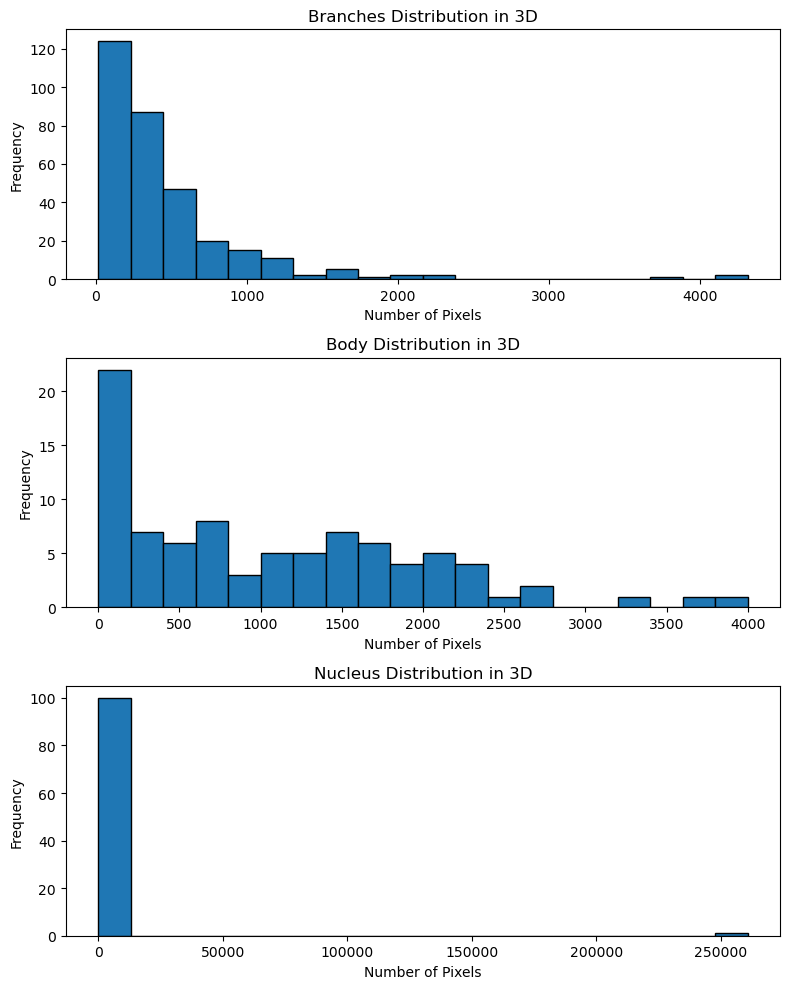

In [43]:
# Plot the statistics
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot distribution of Branches
axs[0].hist(n_pixels_branch, bins=20, edgecolor='black')
axs[0].set_title('Branches Distribution in 3D')
axs[0].set_xlabel('Number of Pixels')
axs[0].set_ylabel('Frequency')

# Plot distribution of Body
axs[1].hist(n_pixels_body, bins=20, edgecolor='black')
axs[1].set_title('Body Distribution in 3D')
axs[1].set_xlabel('Number of Pixels')
axs[1].set_ylabel('Frequency')

# Plot distribution of Nucleus
axs[2].hist(n_pixels_nucleus, bins=20, edgecolor='black')
axs[2].set_title('Nucleus Distribution in 3D')
axs[2].set_xlabel('Number of Pixels')
axs[2].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()